In [17]:
# 1. IMPORTS AND SETUP
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import re
import string
from sklearn.metrics import accuracy_score, log_loss, f1_score, recall_score, roc_curve, auc, balanced_accuracy_score
from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import random
from cleanlab import Datalab
import seaborn as sns

# Configure device (GPU or CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available on this device")
else:
    device = torch.device("cpu")
    print("MPS is not available, using CPU")

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
plt.rcParams.update({"font.family": "Courier New "})
set2 = sns.color_palette("Set2")
custom_palette = [set2[1], set2[0]] + list(set2[2:])

MPS is available on this device


In [18]:
# Load and inspect the dataset
dataset = load_dataset("SALT-NLP/silent_signals")
print(dataset)

# Convert to pandas dataframe
dataset = dataset["train"]
df = pd.DataFrame(dataset)

# Function to drop duplicates but save those dropped instances in a separate data frame
def drop_duplicates_save(df):
    duplicates = df[df.duplicated(subset=["content"], keep=False)]
    df = df.drop_duplicates(subset=["content"])
    # drop missing values in label and content
    df = df.dropna(subset=["content"])
    if "lable" in df.columns:
        df = df.dropna(subset=["lable"])
    return df, duplicates

# Filter out the informal and formal sentences
df_informal = df[df["type"] == "Informal"]
df_formal = df[df["type"] == "Formal"]
print('With duplicates:', df_informal.shape, df_formal.shape)

# Drop duplicates
df_informal, duplicates_if_1 = drop_duplicates_save(df_informal)
df_formal, duplicates_f_1 = drop_duplicates_save(df_formal)
print('Without duplicates:', df_informal.shape, df_formal.shape)

# Load additional data
null_dataset_formal = pd.read_csv("data/0_data/formal_neg_predictions.csv")
null_dataset_informal = pd.read_csv("data/0_data/informal_neg_predictions.csv")

print('With duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)
# Drop duplicates
null_dataset_informal, duplicates_if_0 = drop_duplicates_save(null_dataset_informal)
null_dataset_formal, duplicates_f_0 = drop_duplicates_save(null_dataset_formal)
print('Without duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)

# Merge datasets
null_dataset = pd.concat([null_dataset_formal, null_dataset_informal])

# Exploratory data analysis
print(null_dataset.info())

DatasetDict({
    train: Dataset({
        features: ['dog_whistle', 'dog_whistle_root', 'ingroup', 'content', 'date', 'speaker', 'chamber', 'subreddit', 'source', 'definition', 'type', 'party'],
        num_rows: 16258
    })
})
With duplicates: (12923, 12) (3335, 12)
Without duplicates: (12901, 12) (3298, 12)
With duplicates: (33563, 16) (34360, 14)
Without duplicates: (33057, 16) (34212, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 67269 entries, 0 to 34359
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dog_whistle       67269 non-null  object 
 1   dog_whistle_root  67269 non-null  object 
 2   ingroup           67269 non-null  object 
 3   content           67269 non-null  object 
 4   date              67269 non-null  object 
 5   speaker           33045 non-null  object 
 6   chamber           33057 non-null  object 
 7   community         16 non-null     object 
 8   speech_id         26072

In [19]:
# count number unique values in dog_whistles_root column in df_informal, unique number in ingroup and community
print("Informal dataset unique values in dog_whistles_root column:", df_informal["dog_whistle_root"].nunique())
print("Informal dataset unique values in ingroup column:", df_informal["ingroup"].nunique())
print("Informal dataset unique values in subreddit column:", df_informal["subreddit"].nunique())
print("Length of informal dataset:", len(df_informal))
print("Start date of informal dataset:", df_informal["date"].min())
print("End date of informal dataset:", df_informal["date"].max())

Informal dataset unique values in dog_whistles_root column: 298
Informal dataset unique values in ingroup column: 18
Informal dataset unique values in subreddit column: 47
Length of informal dataset: 12901
Start date of informal dataset: 01/01/2014
End date of informal dataset: 12/31/2022


In [ ]:
# count number unique values in dog_whistles_root column in null dtata informal, unique number in ingroup and community
print("Null dataset informal unique values in dog_whistles_root column:", null_dataset_informal["dog_whistle_root"].nunique())
print("Null dataset informal unique values in ingroup column:", null_dataset_informal["ingroup"].nunique())
print("Null dataset informal unique values in subreddit column:", null_dataset_informal["subreddit"].nunique())
print("Length of null dataset informal:", len(null_dataset_informal))
print("Start date of null dataset informal:", null_dataset_informal["date"].min())
print("End date of null dataset informal:", null_dataset_informal["date"].max())

Null dataset informal unique values in dog_whistles_root column: 299
Null dataset informal unique values in ingroup column: 18
Null dataset informal unique values in subreddit column: 39
Length of null dataset informal: 34212
Start date of null dataset informal: 2008-06-03
End date of null dataset informal: 2023-09-08


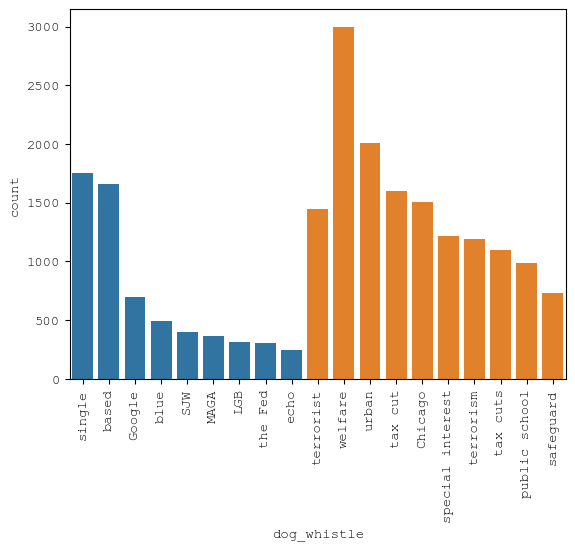

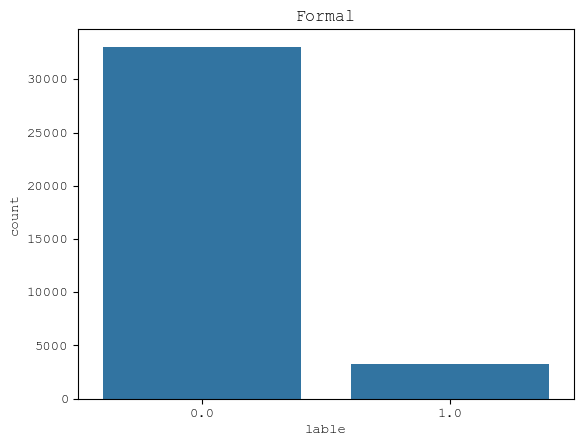

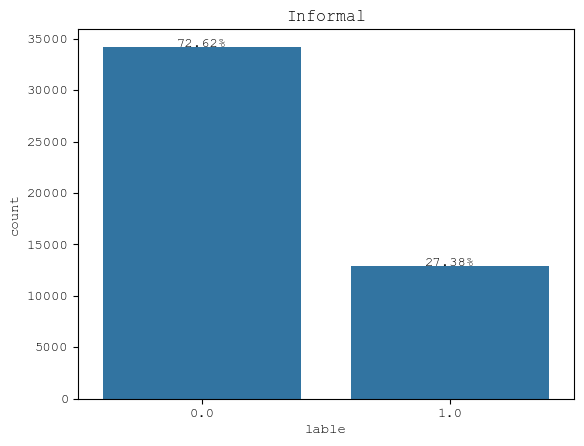

              lable
count  47113.000000
mean       0.273831
std        0.445928
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [21]:
# Count plot of informal dog_whistle and formal dog_whistle
# Top 10 dog whistles
sns.countplot(x='dog_whistle', 
              data=null_dataset_informal, 
              order=null_dataset_informal['dog_whistle'].value_counts().iloc[:10].index)
sns.countplot(x='dog_whistle', 
              data=null_dataset_formal, 
              order=null_dataset_formal['dog_whistle'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.show()

# Join datasets
df_informal = pd.concat([df_informal, null_dataset_informal])
# Label missing values as 1 in label column
df_informal['lable'] = df_informal['lable'].fillna(1)

# Join null formal data and original formal data
df_formal = pd.concat([df_formal, null_dataset_formal])
# Label missing values as 0 in label column
df_formal['lable'] = df_formal['lable'].fillna(1)

# Count plot label column of informal and formal
sns.countplot(x='lable', data=df_formal)
plt.title('Formal')
plt.show()

ax = sns.countplot(x='lable', data=df_informal)
# Add percentage of each class
total = len(df_informal)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")

plt.title('Informal')
plt.show()

# Describe the data
print(df_informal.describe())

In [22]:
df_formal.head()

,dog_whistle,dog_whistle_root,ingroup,content,date,speaker,chamber,subreddit,source,definition,type,party,community,speech_id,speaker_bioguide,in_group,lable
2941,welfare,welfare,racist,Very few Americans would disagree that our wel...,03/21/1995,FRANK RIGGS,H,None,Stanford Congressional Record,racial minorities receive government aid that ...,Formal,R,NaN,NaN,NaN,NaN,1.0
2942,tax cut,cut taxes,racist,The Republicans are so mean to kids in this we...,03/23/1995,HAROLD FORD,H,None,Stanford Congressional Record,Don't spend tax money on minorities,Formal,D,NaN,NaN,NaN,NaN,1.0
2943,tax cut,cut taxes,racist,At the same time it supports a plan that would...,02/13/2003,STENY HOYER,H,None,Stanford Congressional Record,Don't spend tax money on minorities,Formal,D,NaN,NaN,NaN,NaN,1.0
2944,tax cut,cut taxes,racist,Well. this tax cut for the wealthy and tax cut...,10/26/1995,XAVIER BECERRA,H,None,Stanford Congressional Record,Don't spend tax money on minorities,Formal,D,NaN,NaN,NaN,NaN,1.0
2945,tax cuts,cut taxes,racist,So we do need to regain some of the lost reven...,03/23/1988,MICHAEL LOWRY,H,None,Stanford Congressional Record,Don't spend tax money on minorities,Formal,D,NaN,NaN,NaN,NaN,1.0


In [23]:
# Extract data for model training
raw_texts = df_informal['content'].tolist()
labels = df_informal['lable'].tolist()
dog_whistles = df_informal['dog_whistle'].tolist()

# Initialize BERT for embeddings
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-cased')
model = BertModel.from_pretrained('google-bert/bert-base-cased').to(device)

def get_embeddings_in_batches(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=512
        ).to(device)
        with torch.no_grad():
            outputs = model(**tokens)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        all_embeddings.append(embeddings.cpu().numpy())
    return np.concatenate(all_embeddings, axis=0)

# Get embeddings for the dataset
embeddings_np_informal = get_embeddings_in_batches(raw_texts, batch_size=32)

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Train classifier using cross-validation
clf = LogisticRegression(max_iter=1000, random_state=seed)
pred_probs = cross_val_predict(
    clf, embeddings_np_informal, labels, method="predict_proba", cv=cv
)

5. Data Quality Analysis with Cleanlab

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 7833 issues found in the dataset.
Dataset Information: num_examples: 47113, num_classes: 2

Here is a summary of various issues found in your data:

    issue_type  num_issues
         label        6525
       outlier        1142
near_duplicate         165
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having l

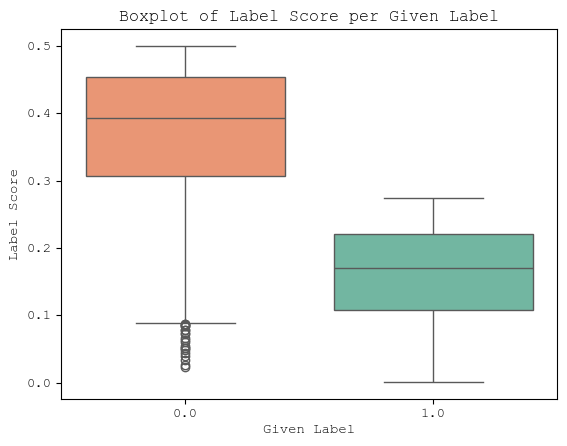

In [24]:
# Use Cleanlab to find and analyze data quality issues
data_dict = {"texts": raw_texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels")
lab.find_issues(pred_probs=pred_probs, features=embeddings_np_informal)
lab.report()

# Extract label issues
label_issues = lab.get_issues("label")
identified_label_issues = label_issues[label_issues["is_label_issue"] == True]

# Create dataframe with suggested labels
data_with_suggested_labels = pd.DataFrame({
    "dog_whistles": dog_whistles, 
    "text": raw_texts, 
    "given_label": labels, 
    "suggested_label": label_issues["predicted_label"], 
    "problem": identified_label_issues["is_label_issue"], 
    "label_score": identified_label_issues["label_score"]
})
potential_wrong_label = data_with_suggested_labels.dropna(subset=["problem"]).sort_values(by="label_score", ascending=False)

# Save potential wrong labels for review
potential_wrong_label.to_csv("data/vetting_instances/potential_wrong_label_new.csv")

# Visualize label score distribution by given label
sns.boxplot(x='given_label', y='label_score', data=potential_wrong_label, palette=custom_palette)
plt.title('Boxplot of Label Score per Given Label')
plt.xlabel('Given Label')
plt.ylabel('Label Score')
plt.savefig('boxplot_label_score_per_given_label.png')
plt.show()

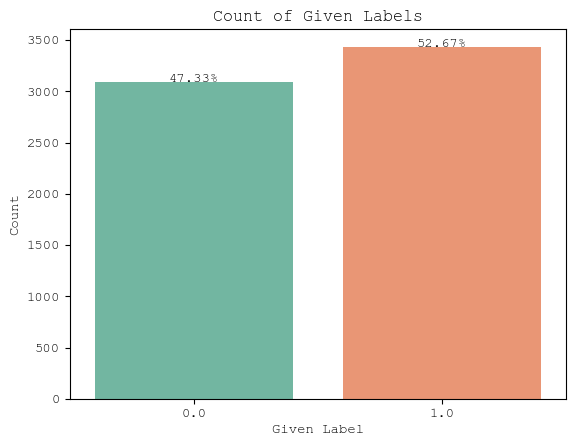

In [25]:
# Visualize given label in a barplot with the percentage of each label on top 
ax =sns.countplot(x='given_label', data=potential_wrong_label, palette='Set2')
total = len(potential_wrong_label) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")
plt.title('Count of Given Labels')
plt.xlabel('Given Label')
plt.ylabel('Count')
plt.show()



In [26]:
# extract near duplicates
near_duplicate = lab.get_issues("near_duplicate")

# Create dataframe with outliers and text from lab based on index so filter out the non outliers

near_duplicate_df = pd.DataFrame({
    "dog_whistles": dog_whistles, 
    "text": raw_texts, 
    "given_label": labels,
    "problem": near_duplicate["is_near_duplicate_issue"],
    "near_duplicate_score": near_duplicate["near_duplicate_score"],
    "sets": near_duplicate["near_duplicate_sets"],
})
near_duplicate_df = near_duplicate_df[near_duplicate_df["problem"] == True]

6. Label Review and Correction

2000
1869


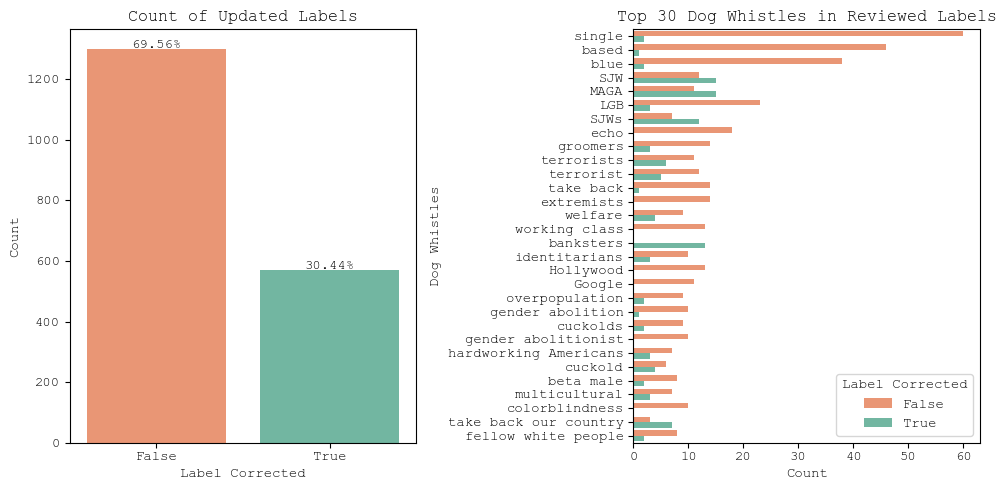

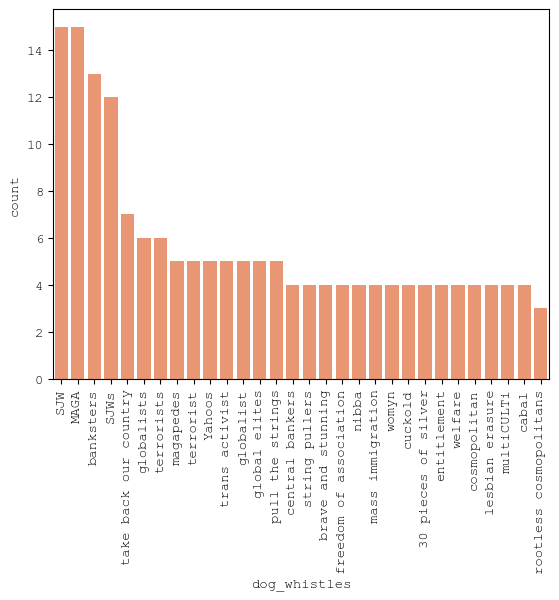

In [27]:
# Load manually reviewed labels
reviewed_labels = pd.read_csv('data/vetting_instances/reviewed_labels.csv')
print(len(reviewed_labels))
# Remove instances marked for removal
reviewed_labels = reviewed_labels[~reviewed_labels['reviewer_notes'].str.contains('remove', case=False, na=False)]
# Remove instances marked as unsure usure Unsure
reviewed_labels = reviewed_labels[~reviewed_labels['reviewer_notes'].str.contains('unsure|usure', case=False, na=False)]
print(len(reviewed_labels))
# Count labels that were changed during review and make the plot only half as wide
reviewed_labels['updated'] = reviewed_labels['given_label'] != reviewed_labels['final_label']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Count of Updated Labels
ax1 = axes[0]
sns.countplot(x='updated', data=reviewed_labels, palette=custom_palette, ax=ax1)
total = len(reviewed_labels)
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")
ax1.set_title('Count of Updated Labels')
ax1.set_xlabel('Label Corrected')
ax1.set_ylabel('Count')

# Plot 2: Top 30 Dog Whistles with Potential Wrong Labels
ax2 = axes[1]
sns.countplot(y='dog_whistles', data=reviewed_labels, 
              hue='updated', 
              order=reviewed_labels['dog_whistles'].value_counts().iloc[:30].index, 
              palette=custom_palette, ax=ax2)
ax2.set_ylabel('Dog Whistles')
ax2.set_xlabel('Count')
ax2.legend(title='Label Corrected')
ax2.set_title('Top 30 Dog Whistles in Reviewed Labels')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('plots/combined_label_update_plots.png', bbox_inches='tight', dpi=300)
plt.show()

# Most updated dog whistles
updated_dog_whistles = reviewed_labels[reviewed_labels['updated'] == True]
sns.countplot(x='dog_whistles', 
              data=updated_dog_whistles, 
              order=updated_dog_whistles['dog_whistles'].value_counts().iloc[:30].index, 
              color='#fc8d62')
plt.xticks(rotation=90)
plt.show()


7. Creating the Corrected Dataset

In [28]:
# Load potential wrong labels
potential_wrong_label = pd.read_csv('data/vetting_instances/potential_wrong_label.csv')

# Drop reviewed instances from potential wrong labels list
potential_wrong_label = potential_wrong_label[~potential_wrong_label['text'].isin(reviewed_labels['text'])]

df_informal = df_informal.reset_index(drop=True)

# Merge the reviewed labels with the informal dataset
df_informal_reviewed = df_informal.merge(
    reviewed_labels.rename(columns={'text': 'content', 'given_label': 'lable'})[['content', 'lable', 'final_label']],
    on='content',
    how='left'
)
print(df_informal_reviewed.index.duplicated().sum())

df_informal_reviewed['lable_x'] = df_informal_reviewed['final_label'].combine_first(df_informal_reviewed['lable_x'])
df_informal_reviewed = df_informal_reviewed.drop(columns=['lable_y', 'final_label'])
df_informal_reviewed = df_informal_reviewed.rename(columns={'lable_x': 'lable'})


# Reassign 'date' and 'subreddit' from the original dataset
df_informal_reviewed['date'] = df_informal['date']
df_informal_reviewed['subreddit'] = df_informal['subreddit']
df_informal_reviewed['ingroup'] = df_informal['ingroup']
# Remove instances that are still in the potential wrong label list 
df_informal_reviewed = df_informal_reviewed[~df_informal_reviewed['content'].isin(potential_wrong_label['text'])]

# Remove instances near duplicates
df_informal_reviewed = df_informal_reviewed[~df_informal_reviewed['content'].isin(near_duplicate_df['text'])]

# Calculate percentage of positive labels
print("Percentage of positive labels:", df_informal_reviewed['lable'].mean())

# Save the corrected dataset
df_informal_reviewed.to_csv('data/informal_reviewed.csv', index=False)

0
Percentage of positive labels: 0.23677433074214965


8. Model Training with Corrected Labels

In [ ]:


# Compare with model trained on original dataset
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_np_informal, labels, test_size=0.1, random_state=seed
)

clf = LogisticRegression(max_iter=1000, random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Original model balanced accuracy:', balanced_accuracy_score(y_test, y_pred))
print('Original model F1 score:', f1_score(y_test, y_pred))
print('Original model recall score:', recall_score(y_test, y_pred))

Original model balanced accuracy: 0.6628260007636053
Original model F1 score: 0.5004757373929591
Original model recall score: 0.4161392405063291


In [ ]:
CSV_PATH = 'data/informal_reviewed.csv'
VAL_SIZE = 0.1

print(f"Loading data from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# Handle different label column names
if 'lable' in df.columns:
    df.rename(columns={'lable': 'label'}, inplace=True)
elif 'label' not in df.columns:
    raise ValueError("CSV must contain either 'lable' or 'label' column")

# Ensure label is integer
df['label'] = df['label'].astype(int)

required_columns = ['content', 'definition', 'label']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"CSV must contain columns: {required_columns}")

train_df, val_df = train_test_split(
    df,
    test_size=VAL_SIZE,
    random_state=seed,
    stratify=df['label']
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# RoBERTa only needs content and label
roberta_train = train_df[['content', 'label']].copy()
roberta_val = val_df[['content', 'label']].copy()

roberta_train.to_csv('data/roberta_train.csv', index=False)
roberta_val.to_csv('data/roberta_val.csv', index=False)

# Format prompt for Gemma
def format_prompt(row):
    return f"""You are a helpful assistant participating in a content moderation task of dog whistle detection. A dogwhistle is the use of coded or suggestive language in political messaging to garner support from a particular group without provoking opposition. Does the following sentence contain a dog whistle? {row['content']}"""

# Create Gemma versions with prompts
gemma_train = train_df.copy()
gemma_val = val_df.copy()

gemma_train['text'] = gemma_train.apply(format_prompt, axis=1)
gemma_val['text'] = gemma_val.apply(format_prompt, axis=1)

# Select only needed columns for Gemma
gemma_train = gemma_train[['content', 'label']]
gemma_val = gemma_val[['content', 'label']]

gemma_train.to_csv('data/gemma_train.csv', index=False)
gemma_val.to_csv('data/gemma_val.csv', index=False)

print("\nData Statistics:")
print(f"Total examples: {len(df)}")
print(f"Label distribution in full dataset:")
print(df['label'].value_counts(normalize=True))
print(f"\nLabel distribution in training set:")
print(train_df['label'].value_counts(normalize=True))
print(f"\nLabel distribution in validation set:")
print(val_df['label'].value_counts(normalize=True))

Loading data from: data/informal_reviewed.csv
Training set size: 38090
Validation set size: 4233

Data Statistics:
Total examples: 42323
Label distribution in full dataset:
label
0    0.763226
1    0.236774
Name: proportion, dtype: float64

Label distribution in training set:
label
0    0.763219
1    0.236781
Name: proportion, dtype: float64

Label distribution in validation set:
label
0    0.763288
1    0.236712
Name: proportion, dtype: float64


In [ ]:
# Compare with model trained on original dataset

clf_updated = LogisticRegression(max_iter=1000, random_state=seed)
X_train_updated = get_embeddings_in_batches(roberta_train['content'].to_list(), batch_size=32)
X_test_updated = get_embeddings_in_batches(roberta_val['content'].to_list(), batch_size=32)
clf_updated.fit(X_train_updated, roberta_train['label'])
y_pred_updated = clf_updated.predict(X_test_updated)

print('Original model balanced accuracy:', balanced_accuracy_score(roberta_val['label'], y_pred_updated))
print('Original model F1 score:', f1_score(roberta_val['label'], y_pred_updated))
print('Original model recall score:', recall_score(roberta_val['label'], y_pred_updated))

Original model balanced accuracy: 0.7611587410137941
Original model F1 score: 0.650984682713348
Original model recall score: 0.593812375249501


9. Model Comparison and ROC Curve Visualization

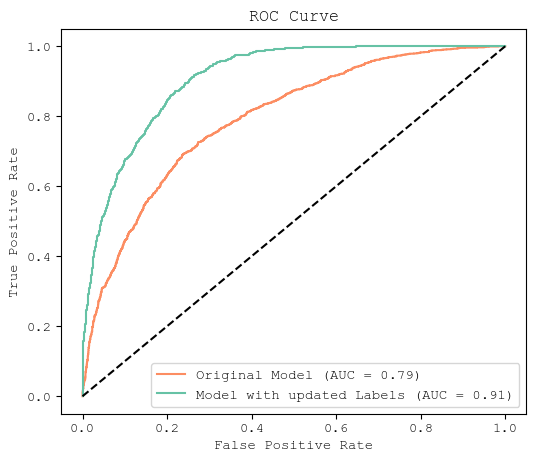

Original Model
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86      3448
         1.0       0.63      0.42      0.50      1264

    accuracy                           0.78      4712
   macro avg       0.72      0.66      0.68      4712
weighted avg       0.76      0.78      0.76      4712

Model with Updated Labels
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      3231
           1       0.72      0.59      0.65      1002

    accuracy                           0.85      4233
   macro avg       0.80      0.76      0.78      4233
weighted avg       0.84      0.85      0.84      4233



In [ ]:
# Compare ROC curves for original and corrected models
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
fpr_updated, tpr_updated, _ = roc_curve(roberta_val['label'], clf_updated.predict_proba(X_test_updated)[:,1])

plt.figure(figsize=(6, 5))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='#fc8d62', label=f'Original Model (AUC = {roc_auc:.2f})')
roc_auc_updated = auc(fpr_updated, tpr_updated)
plt.plot(fpr_updated, tpr_updated, label=f'Model with updated Labels (AUC = {roc_auc_updated:.2f})', color='#66c2a5')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('plots/roc_curve.png', dpi = 300, bbox_inches='tight')
plt.show()

# Print detailed classification reports
from sklearn.metrics import classification_report
print('Original Model')
print(classification_report(y_test, y_pred))
print('Model with Updated Labels')
print(classification_report(roberta_val['label'], y_pred_updated))

10. External Validation

In [ ]:
# Load external validation dataset
test_dataset = load_dataset("SALT-NLP/silent_signals_detection")
test_dataset = test_dataset['train']
test_df = pd.DataFrame(test_dataset)

# Generate predictions
test_raw_texts = test_df['example'].tolist()
test_embeddings = get_embeddings_in_batches(test_raw_texts, batch_size=32)
test_labels = clf_updated.predict(test_embeddings)

# Add predictions to dataframe and evaluate
test_df['label_pred'] = test_labels
test_df['label'] = test_df['label'].apply(lambda x: 1 if x == 'coded' else 0)
accuracy = accuracy_score(test_df['label'], test_df['label_pred'])
print("External validation accuracy:", accuracy)
print(classification_report(test_df['label'], test_df['label_pred']))

External validation accuracy: 0.48514851485148514
              precision    recall  f1-score   support

           0       0.49      0.98      0.65        50
           1       0.00      0.00      0.00        51

    accuracy                           0.49       101
   macro avg       0.24      0.49      0.33       101
weighted avg       0.24      0.49      0.32       101



Plot saved to plots/external_confusion_matrices_simplified.png


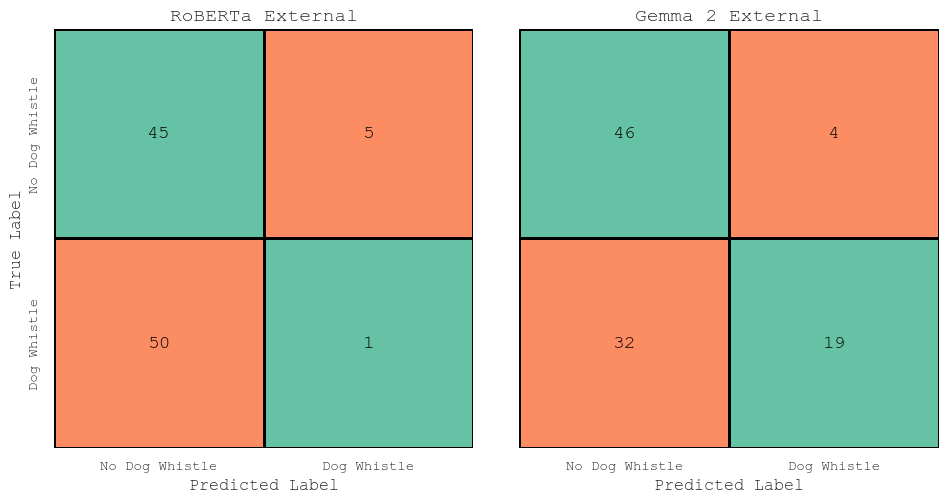

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.colors import ListedColormap

# --- Basic Setup ---
sns.set(style="whitegrid", font="Courier New") # Set style once

# --- Define Colors ---
# Using Set2 palette: set2[1] is greenish, set2[0] is reddish
set2 = sns.color_palette("Set2")
incorrect_color = set2[1] # Reddish (for FP, FN)
correct_color = set2[0]   # Greenish (for TN, TP)

# Create a colormap: Index 0 maps to incorrect_color, Index 1 maps to correct_color
# This map will be used with the 'correctness_matrix' later
custom_cmap = ListedColormap([incorrect_color, correct_color])

# --- Load and Prepare Data ---
try:
    roberta_df = pd.read_csv("eval/roberta_external_predictions.csv")
    gemma_df = pd.read_csv("eval/gemma_external_predictions.csv")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure 'eval/roberta_external_predictions.csv' and 'eval/gemma_external_predictions.csv' exist.")
    exit() # Exit if files are missing

# Convert label columns to integers (can be done in one go)
for df in [roberta_df, gemma_df]:
    df['true_label'] = df['true_label'].astype(int)
    df['predicted_label'] = df['predicted_label'].astype(int)

# --- Compute Confusion Matrices ---
cm_roberta = confusion_matrix(roberta_df['true_label'], roberta_df['predicted_label'])
cm_gemma = confusion_matrix(gemma_df['true_label'], gemma_df['predicted_label'])
labels = ["No Dog Whistle", "Dog Whistle"] # Assuming 0=Negative, 1=Positive

# --- Simplified Plotting Function ---
def plot_simplified_confmat(cm, ax, title, show_yticklabels, cmap):
    """Plots a confusion matrix with specific colors for correct/incorrect predictions."""
    if cm.shape != (2, 2):
        raise ValueError("This function is designed for 2x2 confusion matrices.")

    # Create a matrix indicating correctness (1 for diagonal/correct, 0 for off-diagonal/incorrect)
    # This matrix determines the background color via the cmap.
    correctness_matrix = np.array([[1, 0], [0, 1]]) # TN=1, FP=0, FN=0, TP=1

    sns.heatmap(
        correctness_matrix, # Use this simple matrix for cell *coloring*
        annot=cm,           # Use the *actual* confusion matrix for numbers
        fmt="d",            # Format numbers as integers
        cmap=cmap,          # Use our Red/Green map ([incorrect, correct])
        cbar=False,         # No color bar needed for binary correctness
        xticklabels=labels,
        yticklabels=labels if show_yticklabels else False,
        linewidths=1,
        linecolor='black',
        ax=ax,
        square=True,        # Ensure cells are square
        annot_kws={"size": 14, "color": "black"}, # Adjust annotation appearance
        vmin=0,             # Explicitly set scale for the correctness_matrix
        vmax=1
    )
    ax.set_xlabel("Predicted Label", fontsize=12)
    if show_yticklabels:
        ax.set_ylabel("True Label", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)

# --- Create and Save Plot ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # Adjusted size slightly

plot_simplified_confmat(cm_roberta, axes[0], "RoBERTa External", True, custom_cmap)
plot_simplified_confmat(cm_gemma, axes[1], "Gemma 2 External", False, custom_cmap) # Hide y-labels for the second plot

plt.tight_layout(pad=1.5) # Add padding
plt.savefig("plots/external_confusion_matrices_simplified.png", dpi=300, bbox_inches='tight')
print("Plot saved to plots/external_confusion_matrices_simplified.png")
plt.show()